In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc
import plotly.io as pio
import seaborn as sns


# 1. Data Preparation

In [2]:
# Load provided air data from 2021
dataset = pq.ParquetDataset('c:\\Users\\lukas\\OneDrive - Imperial College London\\0_Sustainable Transport\\2021_COP26',
                            ) # filters=[('columnName', 'in', filterList)]
df = dataset.read(use_threads=True).to_pandas()

In [3]:
path_flights = os.getcwd() + '/data/data_flight_economy_business.xlsx'

data_all = pd.read_excel(path_flights,sheet_name='combined')
data_direct = pd.read_excel(path_flights,sheet_name='direct')
data_non_direct = pd.read_excel(path_flights,sheet_name='non_direct')

airports = airportsdata.load()

In [4]:
data_all.columns

Index(['origin_airport', 'total_delegates', 'destination_airport',
       'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn',
       'co2_kg', 'nox_kg', 'hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg',
       'sulphates_kg', 'Split Econ/Busi', 'Seats Economy', 'Seats Business',
       'total_kg_co2', 'pp_kg_co2'],
      dtype='object')

In [5]:
df.columns

Index(['callsign', 'icao_address', 'flight_number', 'tail_number',
       'aircraft_type_icao', 'aircraft_engine_type', 'origin_airport',
       'origin_airport_name', 'origin_country', 'destination_airport',
       'destination_airport_name', 'destination_country',
       'scheduled_departure_time_utc', 'scheduled_arrival_time_utc',
       'first_waypoint_time', 'last_waypoint_time', 'duration_hours',
       'total_distance_km', 'great_circle_distance_km',
       'longitude_first_waypoint', 'longitude_last_waypoint', 'longitude_min',
       'longitude_max', 'latitude_first_waypoint', 'latitude_last_waypoint',
       'latitude_min', 'latitude_max', 'altitude_first_waypoint',
       'altitude_last_waypoint', 'altitude_min', 'altitude_max', 'n_wypts',
       'n_terrestrial', 'n_satellites', 'n_interpolate', 'n_extrapolate',
       'n_great_circle', 'extrap_trajectory_start', 'extrap_trajectory_end',
       'trajectory_complete', 'great_circle_trajectory', 'est_origin_airport',
       'es

In [6]:
range(0, 178)

range(0, 178)

In [7]:
data_all['duration_hours'] = 0

TESTING TO USE DURATION HOURS

In [8]:
# Calculate mean duration hours for the first 179 rows
mean_duration_first = data_all.iloc[:179].apply(
    lambda row: df[(df.iloc[:, 4] == row[4]) & 
                   (df.iloc[:, 6] == row[0]) &
                   (df.iloc[:, 9] == row[2]) & 
                   (df.iloc[:, 55] == row[3])]['duration_hours'].mean(),
    axis=1
)

# Calculate mean duration hours for the remaining rows
mean_duration_remaining = data_all.iloc[179:].apply(
    lambda row: df[(df.iloc[:, 4] == row[4]) & 
                   (df.iloc[:, 6] == row[0]) &
                   (df.iloc[:, 9] == 'OMDB') & 
                   (df.iloc[:, 55] == row[3])]['duration_hours'].mean(),
    axis=1
)

# Assign mean duration hours to the DataFrame
data_all['duration_hours'] = pd.concat([mean_duration_first, mean_duration_remaining])


C:\Users\lukas\AppData\Local\Temp\ipykernel_21684\3542232524.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda row: df[(df.iloc[:, 4] == row[4]) &
C:\Users\lukas\AppData\Local\Temp\ipykernel_21684\3542232524.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.iloc[:, 6] == row[0]) &
C:\Users\lukas\AppData\Local\Temp\ipykernel_21684\3542232524.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df.iloc[:, 9] == row[2]) 

In [9]:
data_all

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg,Split Econ/Busi,Seats Economy,Seats Business,total_kg_co2,pp_kg_co2,duration_hours
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,574.385162,0.560376,0.011436,0.128205,36,5,3.172736e+05,71.960449,0.44
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,143944.442097,140.433602,2.865992,0.098361,303,33,1.315651e+07,1731.575913,13.91
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,64061.196967,62.498729,1.275484,0.180672,125,28,4.811404e+06,1382.587424,8.27
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,64317.290666,62.748576,1.280583,0.098361,245,27,9.508812e+05,773.703171,7.41
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,89518.782277,87.335397,1.782355,0.180672,126,28,5.083146e+06,1932.020450,10.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,140489.605698,137.063030,2.797205,0.098361,289,32,2.248090e+03,0.000000,13.61
272,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,140489.605698,137.063030,2.797205,0.098361,289,32,2.248090e+03,0.000000,13.61
273,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,52050.344138,50.780824,1.036343,0.098361,269,29,8.971847e+02,0.000000,5.89
274,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,32935.246164,32.131947,0.655754,0.065972,163,12,9.667126e+02,0.000000,5.46


In [37]:
data_all['duration_hours'].isnull().sum()

7

In [38]:
data_all.dropna(subset=['Seats Economy', 'Seats Business'], inplace=True)

# Convert 'Seats Economy' and 'Seats Business' to integers
data_all['Seats Economy'] = data_all['Seats Economy'].astype(int)
data_all['Seats Business'] = data_all['Seats Business'].astype(int)

# data_all['Seats Economy'] = data_all['Seats Economy'] * data_all['assumed_load_factor']
# data_all['Seats Business'] = data_all['Seats Business'] * data_all['assumed_load_factor']


Get latitude and longitude for origin and destination

In [39]:
def get_coordinates(row, column_name):
    airport_code = row[column_name]
    airport_info = airports.get(airport_code)
    if airport_info:
        return pd.Series([airport_info['lat'], airport_info['lon']])
    else:
        print("airport miss")
        # print(data_all.loc[row])
        return pd.Series([None, None])

# Apply the function to get latitude and longitude for origin and destination airports
data_all[['origin_lat', 'origin_lon']] = data_all.apply(lambda row: get_coordinates(row, 'origin_airport'), axis=1)
data_all[['dest_lat', 'dest_lon']] = data_all.apply(lambda row: get_coordinates(row, 'destination_airport'), axis=1)


Calculate distance between origin and destination

In [40]:
def calculate_distance(row):
    origin_coord = (row['origin_lat'], row['origin_lon'])
    dest_coord = (row['dest_lat'], row['dest_lon'])
    return geodesic(origin_coord, dest_coord).kilometers

# Drop rows with NaN values in latitude and longitude columns
data_all.dropna(subset=['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon'], inplace=True)

# Apply the function to calculate distances
data_all['distance_km'] = data_all.apply(calculate_distance, axis=1)

data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,dest_lon,distance_km,total_seats,total_seats_factor_business,economy_co2_pp,business_co2_pp,total_delegats_inc_hub,total_co2,economy_new,business_new
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,55.364399,115.950338,41,56.125,26.283995,105.793079,8786,6.322445e+05,0.0,0.0
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,55.364399,12217.959202,336,435.825,848.256657,3414.233043,3618,7.961570e+06,0.0,0.0
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,55.364399,5855.097793,153,237.700,692.166190,2785.968916,2640,5.677826e+06,0.0,0.0


In [41]:
dubai_airport = pd.DataFrame({'dest_lat_A': [airports.get('OMDB')['lat']],
                     'origin_lon_A': [airports.get('OMDB')['lon']]})

delegate_airports = data_all[['dest_lat','origin_lon']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['dest_lat_A'].iloc[0], dubai_airport['origin_lon_A'].iloc[0])
    coord_B = (row['dest_lat'], row['origin_lon'])
    return geodesic(coord_A, coord_B).kilometers

data_all.loc[data_all['origin_airport'] == data_all['destination_airport'], 'distance_km'] = delegate_airports.apply(calculate_distance,axis=1).astype(np.int64)
data_all.iloc[:3]

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,dest_lon,distance_km,total_seats,total_seats_factor_business,economy_co2_pp,business_co2_pp,total_delegats_inc_hub,total_co2,economy_new,business_new
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,55.364399,115.950338,41,56.125,26.283995,105.793079,8786,6.322445e+05,0.0,0.0
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,55.364399,12217.959202,336,435.825,848.256657,3414.233043,3618,7.961570e+06,0.0,0.0
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,55.364399,5855.097793,153,237.700,692.166190,2785.968916,2640,5.677826e+06,0.0,0.0


Calculate CO2 per person

In [42]:
factor_business = 4.025

data_all['total_seats'] = data_all['Seats Economy'] + data_all['Seats Business'] 
data_all['total_seats_factor_business'] = (data_all['Seats Economy'] + data_all['Seats Business'] * factor_business)

data_all['economy_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Economy'] / data_all['total_seats_factor_business']) / data_all['Seats Economy']
data_all['business_co2_pp'] = (data_all['co2_kg'] * data_all['Seats Business'] * factor_business /  data_all['total_seats_factor_business']) / data_all['Seats Business']

In [43]:
# Assuming data_all is your DataFrame containing the relevant columns

# Count occurrences of each aircraft type before grouping
occurrences = data_all['aircraft_type_icao'].value_counts().reset_index()
occurrences.columns = ['aircraft_type_icao', 'occurrences']

# Grouping by aircraft_type_icao and calculating the average of other columns
grouped_data = data_all.groupby('aircraft_type_icao').agg({
    'total_seats': lambda x: round(x.mean(), 1),
    'distance_km': lambda x: round(x.mean(), 1),
    'total_fuel_burn': lambda x: round(x.mean(), 1),
    'duration_hours': lambda x: round(x.mean(),1)
}).reset_index()

# Merge the occurrences information with grouped_data
grouped_data = pd.merge(grouped_data, occurrences, on='aircraft_type_icao', how='left')

# print(grouped_data)

In [44]:
# Define a function to check if the duration is less than 3 hours
def is_short_haul(duration_hours):
    # Check if duration_hours is not NaN and less than 3 hours
    return (not pd.isna(duration_hours)) and duration_hours < 3

# Apply the function to create a new column 'is_short_haul' based on 'duration_hours'
grouped_data['is_short_haul'] = grouped_data['duration_hours'].apply(is_short_haul)
data_all['is_short_haul'] = data_all['duration_hours'].apply(is_short_haul)
grouped_data.iloc[:3]

,aircraft_type_icao,total_seats,distance_km,total_fuel_burn,duration_hours,occurrences,is_short_haul
0,A20N,100.0,2338.7,5729.6,2.9,3,True
1,A21N,124.0,2576.2,8190.8,3.4,4,False
2,A310,128.0,874.5,5839.9,1.4,1,True


In [45]:
# # Definitely long haul : A359, A388, B77L, B77W, B788,
# short_medium_aircraft = ['A20N','A21N','B38M','B734','B748','B752','B763','BCS3','DC87','E190','RJ85','E290','B733',]
# short_haul_aircraft = ['A310','A319','A320','A321','A333','AT72','AT76','AT75','B735','B737','B738','B737','E190','B762','CRJ2','D228','DH8D','E145','E170',
#                        'A20N','A21N','B734','B752','B763','DC87','RJ85']

# # Define a function to check if the aircraft_type_icao is in the short_haul_aircraft list
# def is_short_haul(aircraft_type):
#     return aircraft_type in short_haul_aircraft

# # Apply the function to create a new column 'is_short_haul'
# grouped_data['is_short_haul'] = grouped_data['aircraft_type_icao'].apply(is_short_haul)
# data_all['is_short_haul'] = data_all['aircraft_type_icao'].apply(is_short_haul)

In [118]:
# data_all[data_all['is_short_haul'] == True]
grouped_data[grouped_data['is_short_haul'] == False].count()

aircraft_type_icao    18
total_seats           18
distance_km           18
total_fuel_burn       18
duration_hours        17
occurrences           18
is_short_haul         18
dtype: int64

Assign delegate number to flight from hub-airport to Dubai

In [20]:
data_all['total_delegats_inc_hub'] = data_all['total_delegates']

In [21]:

occurrence_count = {}

# Replace zeros in the value column with the nth occurrence value for each reference value
for index, row in data_all.iterrows():
    if row['total_delegates'] == 0:
        reference_value = row['destination_airport']
        if reference_value not in occurrence_count:
            occurrence_count[reference_value] = 0
        else:
            occurrence_count[reference_value] += 1
        nth_occurrence = occurrence_count[reference_value]
        replacement_value = data_all[data_all['destination_airport'] == reference_value]['total_delegates'].iloc[nth_occurrence]
        data_all.at[index, 'total_delegats_inc_hub'] = replacement_value


In [22]:
print('Total delegates: ',data_all['total_delegates'].sum())
print('Total delegates with people who have to travel twice: ',data_all['total_delegats_inc_hub'].sum())

Total delegates:  79872
Total delegates with people who have to travel twice:  96413


## 1.1 Calculating CO2 Emission

In [23]:
data_all['total_co2'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['co2_kg'] * 2 # two directions

In [24]:
data_all

,origin_airport,total_delegates,destination_airport,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,...,origin_lon,dest_lat,dest_lon,distance_km,total_seats,total_seats_factor_business,economy_co2_pp,business_co2_pp,total_delegats_inc_hub,total_co2
0,OMAA,8786,OMDB,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,...,54.651100,25.252800,55.364399,115.950338,41,56.125,26.283995,105.793079,8786,6.322445e+05
1,SBGR,3618,OMDB,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,...,-46.473057,25.252800,55.364399,12217.959202,336,435.825,848.256657,3414.233043,3618,7.961570e+06
2,ZBAA,2640,OMDB,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,...,116.584999,25.252800,55.364399,5855.097793,153,237.700,692.166190,2785.968916,2640,5.677826e+06
3,WIII,1229,OMDB,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,...,106.655998,25.252800,55.364399,6543.696070,272,353.675,467.054858,1879.895805,1229,1.492744e+06
4,RJTT,1221,OMDB,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,...,139.779999,25.252800,55.364399,7949.313707,154,238.700,963.177350,3876.788835,1221,3.645723e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,...,-80.290116,25.795361,-80.290116,12625.000000,321,417.800,863.615190,3476.051139,74,1.663587e+05
272,KMIA,0,KMIA,0.751742,B77W,114219.191624,360818.426340,2563.752966,9.649549,2.284384,...,-80.290116,25.795361,-80.290116,12625.000000,321,417.800,863.615190,3476.051139,0,0.000000e+00
273,LEBL,0,LEBL,0.698774,B77W,42317.352958,133680.517994,869.466243,6.217029,0.846347,...,2.078460,41.297100,2.078460,5183.000000,298,385.725,346.569494,1394.942213,0,0.000000e+00
274,HRYR,0,HRYR,0.606079,A332,26776.622897,84587.351733,374.152490,2.358692,0.535532,...,30.139500,-1.968630,30.139500,4058.000000,175,211.300,400.318749,1611.282966,233,2.252440e+05


## 1.2 Long and short haul flights

In [35]:
short_haul_mask = grouped_data['duration_hours'].apply(is_short_haul)

# Get the array of aircraft_type_icao where the condition is True
short_haul_aircraft = grouped_data.loc[short_haul_mask, 'aircraft_type_icao'].values
# short_haul_aircraft

NameError: name 'total_delegates_sum' is not defined

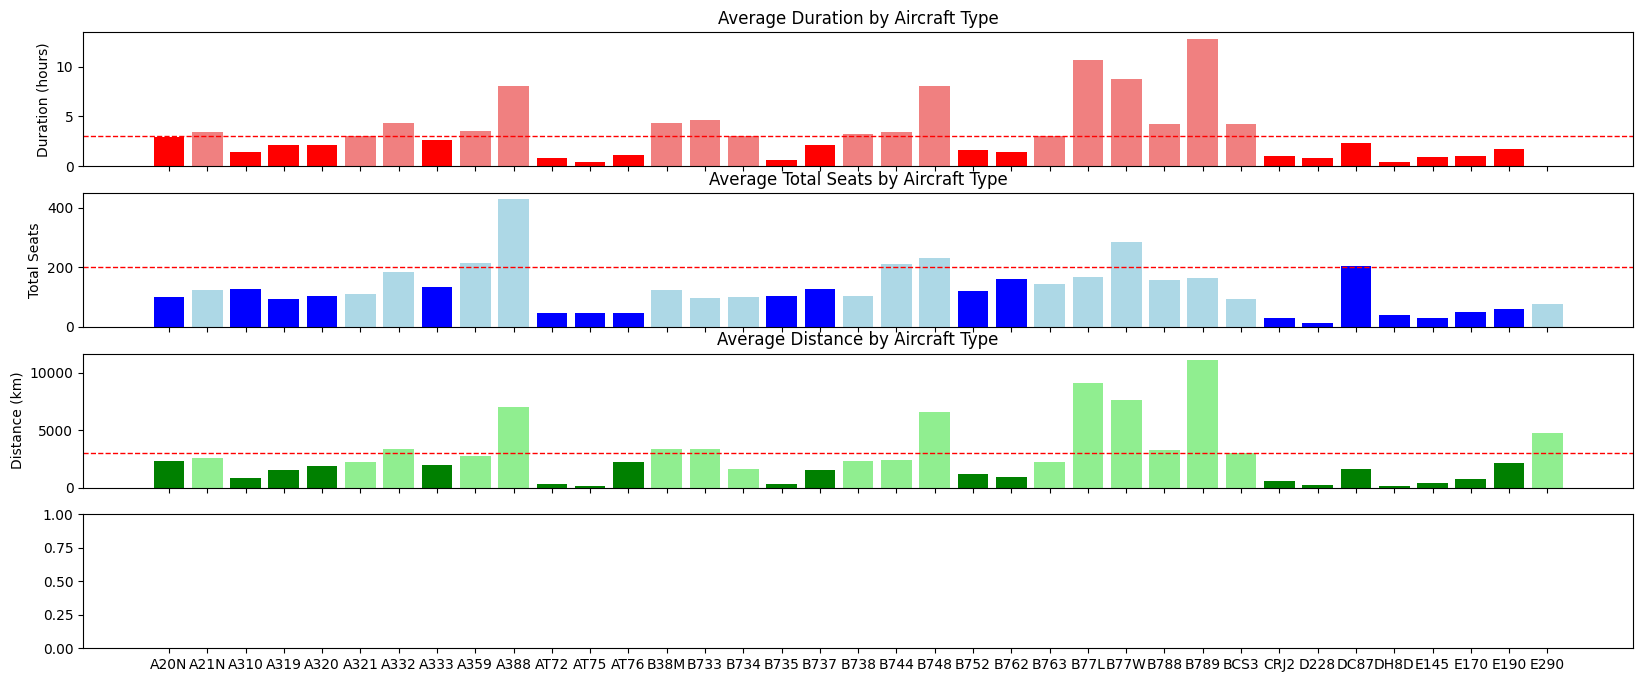

In [26]:

# Create a figure with subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 8), sharex=True)

# Plotting duration_hours
for index, row in grouped_data.iterrows():
    color = 'lightcoral' if row['aircraft_type_icao'] not in short_haul_aircraft else 'red'
    axs[0].bar(row['aircraft_type_icao'], row['duration_hours'], color=color)

axs[0].set_title('Average Duration by Aircraft Type')
axs[0].set_ylabel('Duration (hours)')
axs[0].axhline(y=3, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 8 hours

# Plotting total seats
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs[1].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

axs[1].set_title('Average Total Seats by Aircraft Type')
axs[1].set_ylabel('Total Seats')
axs[1].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200

# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[2].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[2].set_title('Average Distance by Aircraft Type')
axs[2].set_ylabel('Distance (km)')
axs[2].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000

# Plotting total delegates
for aircraft_type in total_delegates_sum.index:
    color = 'peachpuff' if aircraft_type not in short_haul_aircraft else 'orange'
    axs[3].bar(aircraft_type, total_delegates_sum[aircraft_type], color=color)

axs[3].set_title('Sum of Total Delegates by Aircraft Type')
axs[3].set_xlabel('Aircraft Type')
axs[3].set_ylabel('Sum of Total Delegates')

# Calculate the sum of total delegates for each aircraft type
total_delegates_sum = data_all.groupby('aircraft_type_icao')['total_delegates'].sum()

# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

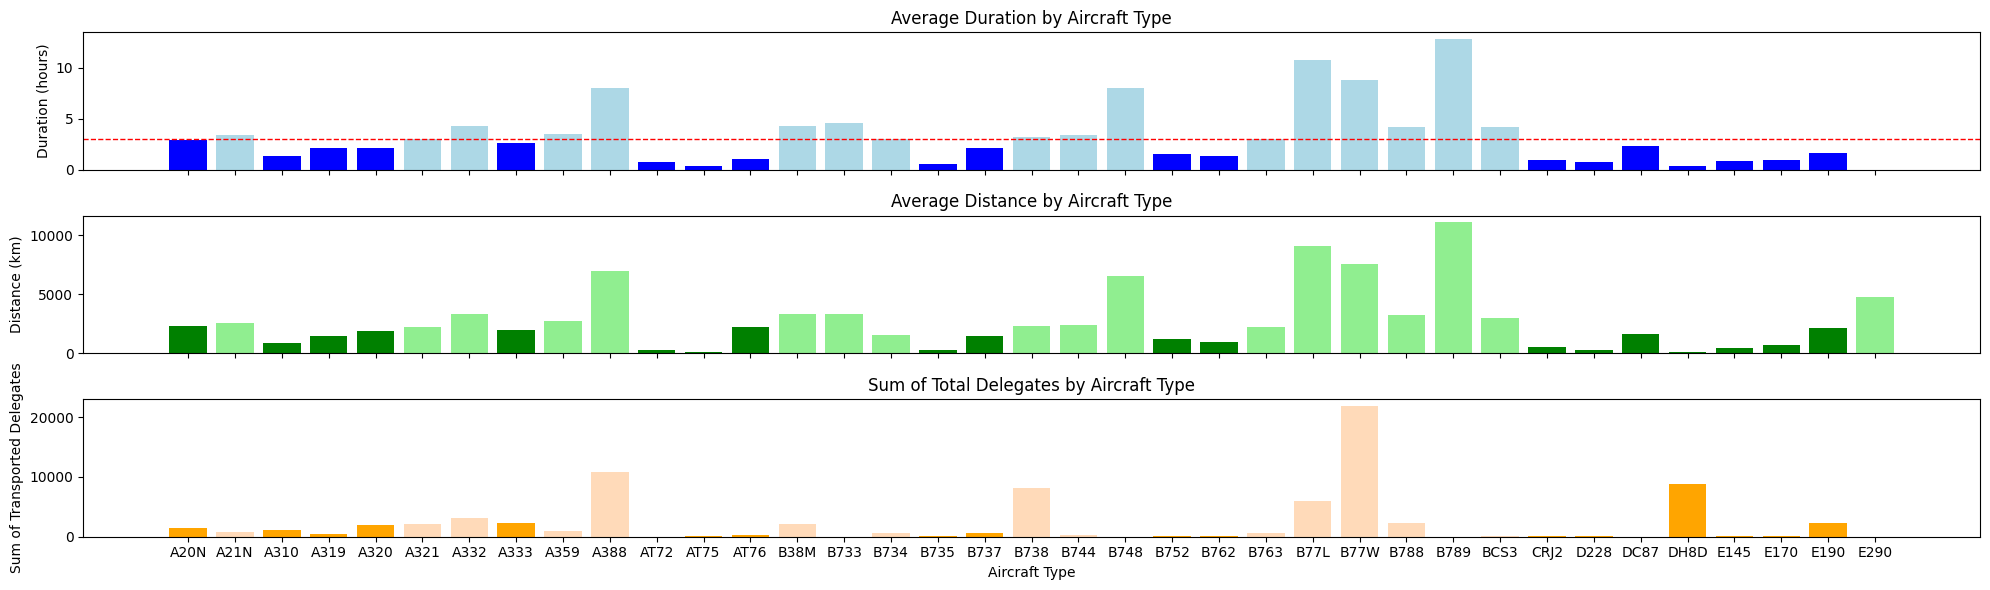

In [250]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 6),sharex=True)


# # Plotting total seats
# for index, row in grouped_data.iterrows():
#     color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
#     axs[0].bar(row['aircraft_type_icao'], row['total_seats'], color=color)

# axs[0].set_title('Average Total Seats by Aircraft Type')
# # axs[0].set_xlabel('Aircraft Type')
# axs[0].set_ylabel('Total Seats')
# axs[0].axhline(y=200, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 200
# Plotting duration_hours
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'lightblue'
    axs[0].bar(row['aircraft_type_icao'], row['duration_hours'], color=color)

axs[0].set_title('Average Duration by Aircraft Type')
axs[0].set_ylabel('Duration (hours)')
axs[0].axhline(y=3, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 8 hours



# Plotting distance
for index, row in grouped_data.iterrows():
    color = 'lightgreen' if row['aircraft_type_icao'] not in short_haul_aircraft else 'green'
    axs[1].bar(row['aircraft_type_icao'], row['distance_km'], color=color)

axs[1].set_title('Average Distance by Aircraft Type')
# axs[1].set_xlabel('Aircraft Type')
axs[1].set_ylabel('Distance (km)')
# axs[1].axhline(y=3000, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 3000


for aircraft_type in total_delegates_sum.index:
    color = 'peachpuff' if aircraft_type not in short_haul_aircraft else 'orange'  # Using lightsalmon for short haul
    axs[2].bar(aircraft_type, total_delegates_sum[aircraft_type], color=color)

axs[2].set_title('Sum of Total Delegates by Aircraft Type')
axs[2].set_xlabel('Aircraft Type')
axs[2].set_ylabel('Sum of Transported Delegates')
#axs[2].tick_params(axis='x', which='both', bottom=True, top=False)  # Show x-axis ticks only for axs[3]

# Calculate the sum of total delegates for each aircraft type
total_delegates_sum = data_all.groupby('aircraft_type_icao')['total_delegates'].sum()






# Rotate x-axis labels for better readability if necessary
# plt.setp(axs[3].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


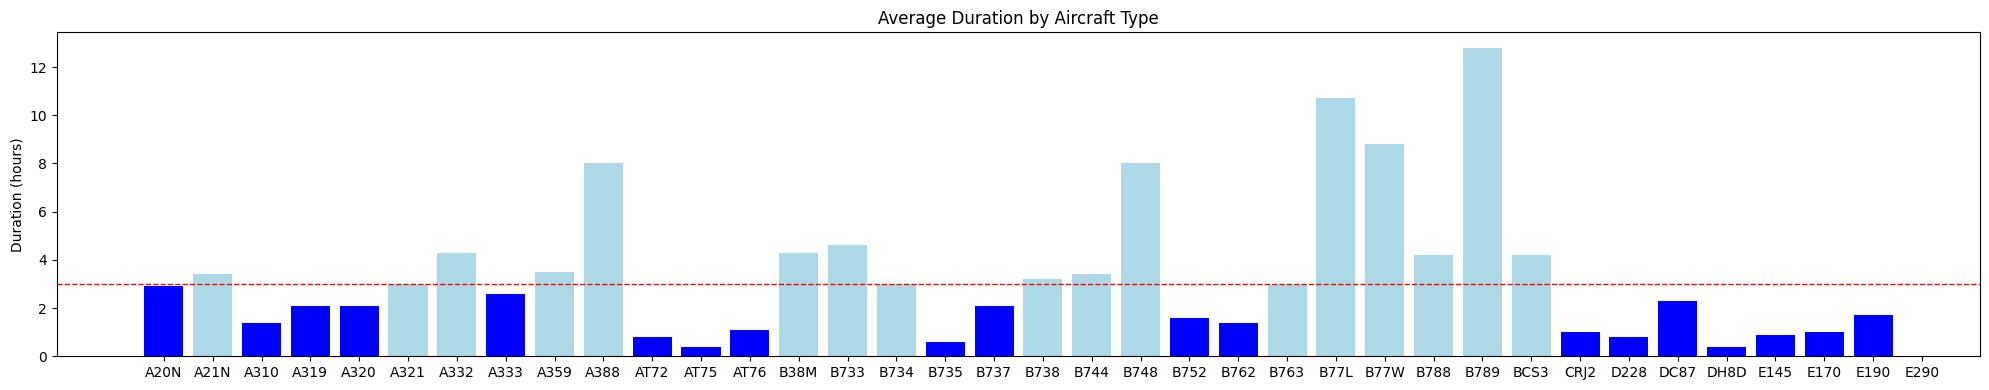

In [90]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(1, 1, figsize=(20, 4), sharex=True)

# Plotting duration_hours
for index, row in grouped_data.iterrows():
    color = 'lightblue' if row['aircraft_type_icao'] not in short_haul_aircraft else 'blue'
    axs.bar(row['aircraft_type_icao'], row['duration_hours'], color=color)

axs.set_title('Average Duration by Aircraft Type')
axs.set_ylabel('Duration (hours)')
axs.axhline(y=3, color='red', linestyle='--', linewidth=1)  # Adding the limit line at 8 hours

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [115]:
grouped_data.loc[data_all['is_short_haul'] == True,'aircraft_type_icao'].count()

8

In [ ]:
# Define offset for annotation
annotation_offset = 10

# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_baseline = baseline_short_business + baseline_short_economy + baseline_long_business + baseline_long_economy
total_short = change_short_business + change_short_economy + change_long_business + change_long_economy
total_medium = change_short_business_new + change_short_economy_new + change_long_business_new + change_long_economy_new

# Calculate total CO2 reduction
total_reduction_short = total_baseline - total_short
total_reduction_medium = total_short - total_medium

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
fig = go.Figure()

fig.add_trace(go.Bar(x=x, y=business_short_haul, name='Business Short Haul', marker_color='blue'))
fig.add_trace(go.Bar(x=x, y=economy_short_haul, name='Economy Short Haul', marker_color='lightblue'))
fig.add_trace(go.Bar(x=x, y=business_long_haul, name='Business Long Haul', marker_color='green'))
fig.add_trace(go.Bar(x=x, y=economy_long_haul, name='Economy Long Haul', marker_color='lightgreen'))

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage = (total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (total_reduction_medium / total_short) * 100
#     rounded_percentage = round(reduction_percentage, 2)
#     fig.add_annotation(x=x[i], y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + 5,
#                        text=f"Total reduction: {rounded_percentage}%",
#                        showarrow=False, xanchor='center', yanchor='bottom')

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage_short = (1 - total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (1 - total_reduction_medium / total_short) * 100
#     rounded_percentage_short = round(reduction_percentage_short, 2)
    
#     reduction_percentage_long = (1 - total_reduction_long / total_baseline) * 100 if scenarios[i] == 'Medium' else (1 - total_reduction_medium / total_medium) * 100
#     rounded_percentage_long = round(reduction_percentage_long, 2)
    
#     fig.add_annotation(x=i, y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + annotation_offset,
#                        text=f"Total reduction: {rounded_percentage_short}% (Short), {rounded_percentage_long}% (Long)",
#                        showarrow=False, xanchor='center', yanchor='bottom')


# Adding labels and title
fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=x, ticktext=scenarios),
    yaxis=dict(title='Total CO2 emission [kg]'),
    title='Stacked Flight Occurrences for Different Scenarios',
    barmode='stack',
    legend=dict(x=1.02, y=1),
    width=800,  # Adjust plot width
    height=500  # Adjust plot height
)

fig.show()


In [96]:
data_all.loc[data_all['is_short_haul'] == True,'distance_km'].sum()

202216.61552421094

In [84]:
data_all.loc[data_all['is_short_haul'] == False,'total_delegates'].sum()

47620

In [94]:
data_all['distance_km'].sum()

1301060.4271685062

In [97]:
1098843/(202216 + 1098843)

0.8445758416797393

# 2. Data Analysis
## 2.1 General

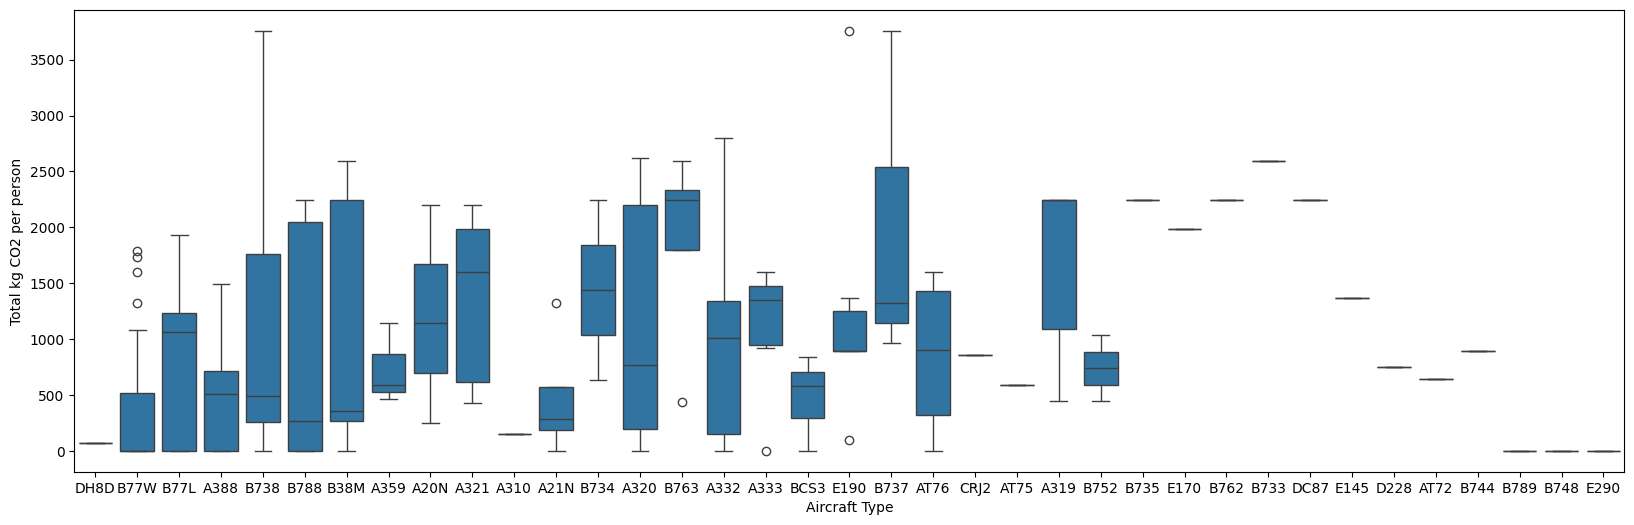

In [47]:
# Boxplot for total_fuel_burn
plt.figure(figsize=(20, 6))
sns.boxplot(x='aircraft_type_icao', y='pp_kg_co2', data=data_all)
# plt.title('Total kg of CO2 per person')
plt.xlabel('Aircraft Type')
plt.ylabel('Total kg CO2 per person')
plt.show()

# # Boxplot for total_fuel_burn
# plt.figure(figsize=(15, 6))
# sns.boxplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_all)
# # plt.title('Total kg of CO2 per person')
# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')
# plt.show()

In [48]:
# plt.figure(figsize=(15, 6))

# # Barplot for average value
# sns.barplot(x='aircraft_type_icao', y='pp_g_co2_km', data=data_direct, estimator=lambda x: sum(x) / len(x), color='lightblue')

# # Add values to the top of the bars
# for p in plt.gca().patches:
#     plt.gca().annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
#                 textcoords='offset points')

# plt.xlabel('Aircraft Type')
# plt.ylabel('Total g CO2 per km')

# plt.show()


## 2.2 Split Economy/Business Class

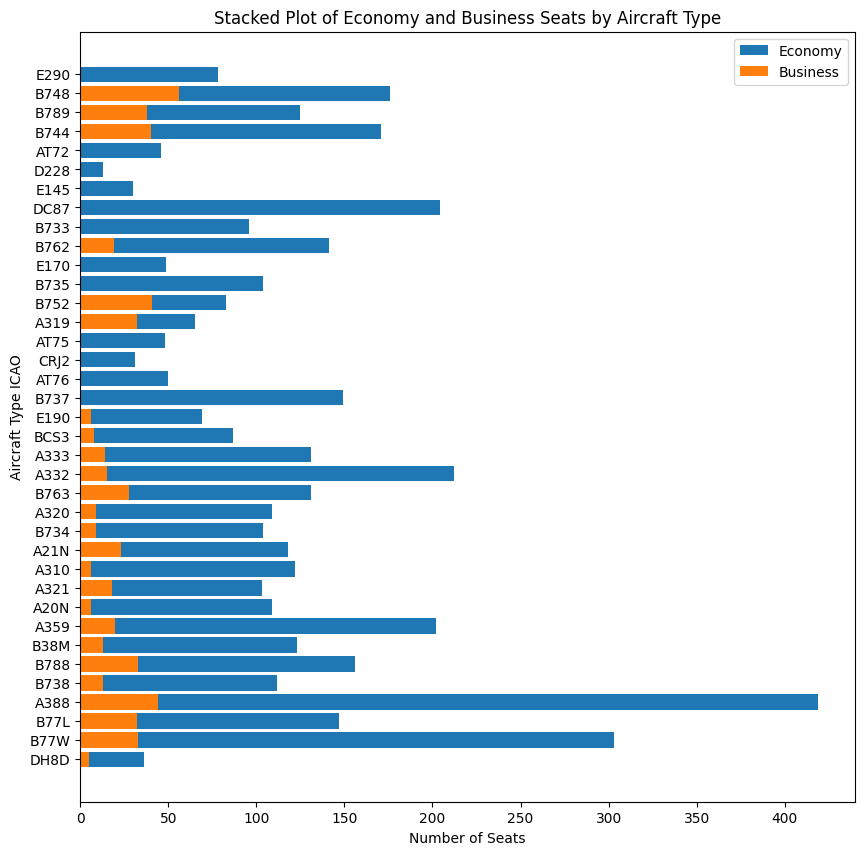

In [49]:

# Plot
plt.figure(figsize=(10, 10))

# Stacked bar plot
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
plt.barh(data_all['aircraft_type_icao'], data_all['Seats Business'],  label='Business') # left=data_all['Seats Economy'],

# Labels and title
plt.xlabel('Number of Seats')
plt.ylabel('Aircraft Type ICAO')
plt.title('Stacked Plot of Economy and Business Seats by Aircraft Type')
plt.legend()

# Show plot
plt.show()


### 2.2.1 CO2 Emission Visualisation

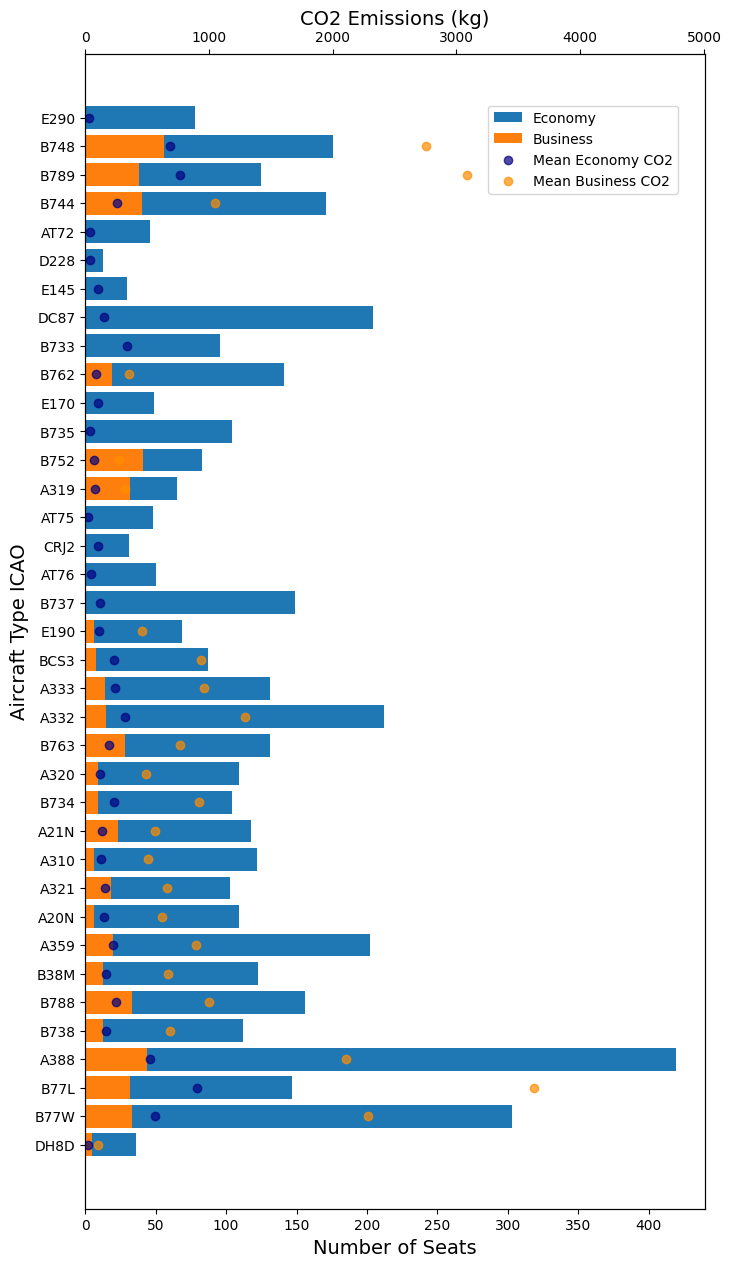

In [50]:
# Calculate mean CO2 emissions for business and economy
mean_business_co2 = data_all.groupby('aircraft_type_icao')['business_co2_pp'].mean()
mean_economy_co2 = data_all.groupby('aircraft_type_icao')['economy_co2_pp'].mean()

# Plot
fig, ax1 = plt.subplots(figsize=(8, 15))

# Stacked bar plot for seats
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Economy'], label='Economy')
ax1.barh(data_all['aircraft_type_icao'], data_all['Seats Business'], label='Business')

# Labels and title for seats
ax1.set_xlabel('Number of Seats', fontsize=14)
ax1.set_ylabel('Aircraft Type ICAO', fontsize=14)
# ax1.set_title('Stacked Plot of Economy and Business Seats by Aircraft Type', fontsize=16)

# Create a second x-axis for CO2 emissions
ax2 = ax1.twiny()
ax2.set_xlabel('CO2 Emissions (kg)', fontsize=14)

ax2.set_xlim(0, data_all[['business_co2_pp', 'economy_co2_pp']].max().max() + 100)

# Plot mean CO2 emissions as points with darker shades
ax2.scatter(mean_economy_co2, mean_economy_co2.index, color='navy', label='Mean Economy CO2', alpha=0.7)
ax2.scatter(mean_business_co2, mean_business_co2.index, color='darkorange', label='Mean Business CO2', alpha=0.7)

# Add legend
# fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
# ax1.legend(loc='upper right', bbox_to_anchor=(1, 1.2))
fig.legend(loc='upper right', bbox_to_anchor=(0.875, 0.85))

# Show plot
plt.show()


# 3 Calculating total emissions

In [51]:
data_all[['origin_airport','destination_airport','total_delegats_inc_hub','aircraft_type_icao','co2_kg',
          'Split Econ/Busi','Seats Economy','Seats Business','economy_co2_pp', 'business_co2_pp', 
          'is_short_haul','total_delegats_inc_hub', 'total_co2']].iloc[:3]

,origin_airport,destination_airport,total_delegats_inc_hub,aircraft_type_icao,co2_kg,Split Econ/Busi,Seats Economy,Seats Business,economy_co2_pp,business_co2_pp,is_short_haul,total_delegats_inc_hub,total_co2
0,OMAA,OMDB,8786,DH8D,1475.189208,0.128205,36,5,26.283995,105.793079,True,8786,6.322445e+05
1,SBGR,OMDB,3618,B77W,369691.457386,0.098361,303,33,848.256657,3414.233043,False,3618,7.961570e+06
2,ZBAA,OMDB,2640,B77L,164527.903430,0.180672,125,28,692.166190,2785.968916,False,2640,5.677826e+06


In [52]:
data_all['economy_new'] = 0.0
data_all['business_new'] = 0.0


# LONG FLIGHTS
condition_short = data_all['is_short_haul'] == False
sensitivity_value = 0.05 # Assumption that 5% change to economy for medium to long haul flights (>3 hours)

data_all.loc[condition_short,'economy_new'] = data_all.loc[condition_short,'Seats Economy'] + data_all.loc[condition_short,'Seats Business'] * sensitivity_value
data_all.loc[condition_short,'business_new'] = data_all.loc[condition_short,'Seats Business'] * (1 - sensitivity_value)


# SHORT FLIGHTS
condition_long = data_all['is_short_haul'] == True
sensitivity_value_short = 0.3 # Assumption that 30% change to economy for short flights (<3 hours)

data_all.loc[condition_long,'economy_new'] = data_all.loc[condition_long,'Seats Economy'] + data_all.loc[condition_long,'Seats Business'] * sensitivity_value_short
data_all.loc[condition_long,'business_new'] = data_all.loc[condition_long,'Seats Business'] * (1 - sensitivity_value_short)


new_co2_economy = data_all['economy_new'] * data_all['economy_co2_pp']
new_co2_business = data_all['business_new'] * data_all['business_co2_pp']

# new emission for whole flight
data_all['flight_co2_reduced'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced'].isnull() | (data_all['flight_co2_reduced'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_new'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced'] * 2
data_all['total_co2_new'].sum()

96182469.33101906

Calculate the effect of short and medium/long flights alone 

In [53]:
data_all.loc[data_all['is_short_haul'] == True,'economy_short'] = data_all.loc[data_all['is_short_haul'] == True,'Seats Economy'] + data_all.loc[data_all['is_short_haul'] == True,'Seats Business'] * sensitivity_value_short
data_all.loc[data_all['is_short_haul'] == True,'business_short'] = data_all.loc[data_all['is_short_haul'] == True,'Seats Business'] * (1 - sensitivity_value_short)

new_co2_economy = data_all['economy_short'] * data_all['economy_co2_pp']# / (data_all['business_new'] + data_all['economy_new'])
new_co2_business = data_all['business_short'] * data_all['business_co2_pp']# /  (data_all['business_new'] + data_all['economy_new'])


data_all['flight_co2_reduced_long'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced_long'].isnull() | (data_all['flight_co2_reduced_long'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced_long'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_long'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced_long'] * 2
data_all['total_co2_long'].sum()

97375801.67944169

In [54]:
data_all.loc[data_all['is_short_haul'] == False,'economy_long'] = data_all.loc[data_all['is_short_haul'] == False,'Seats Economy'] + data_all.loc[data_all['is_short_haul'] == False,'Seats Business'] * sensitivity_value
data_all.loc[data_all['is_short_haul'] == False,'business_long'] = data_all.loc[data_all['is_short_haul'] == False,'Seats Business'] * (1 - sensitivity_value)

new_co2_economy = data_all['economy_long'] * data_all['economy_co2_pp']# / (data_all['business_new'] + data_all['economy_new'])
new_co2_business = data_all['business_long'] * data_all['business_co2_pp']# /  (data_all['business_new'] + data_all['economy_new'])


data_all['flight_co2_reduced_short'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced_short'].isnull() | (data_all['flight_co2_reduced_short'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced_short'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_short'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced_short'] * 2
data_all['total_co2_short'].sum()

96547919.51720122

In [55]:
data_all['flight_co2_reduced_short'].mean() / data_all['co2_kg'].mean()

0.9884322445961586

In [56]:
(data_all['total_co2'].sum() - data_all['total_co2_short'].sum()) + (data_all['total_co2'].sum() - data_all['total_co2_long'].sum())

1558782.5346048176

## Visualisation

In [57]:
data_all['total_co2'].sum()

97741251.86562386

In [66]:
data_all['total_co2_new'].sum()/current_status -1 

-0.015948051665512164

In [61]:
import plotly.graph_objects as go

# Calculate the sum of total_co2
current_status = data_all['total_co2'].sum()

# Calculate the reductions
reduction_long = data_all['total_co2_long'].sum() - current_status 
reduction_short = data_all['total_co2_short'].sum() - current_status

# Calculate percentage reductions
percentage_reduction_long = (reduction_long / current_status) * 100
percentage_reduction_short = (reduction_short / current_status) * 100

total_percentage_reduction = percentage_reduction_long + percentage_reduction_short


# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Change in Total CO2",
    orientation="v",
    measure=["relative", "relative", "relative"],
    x=["Current Status", "Long haul \n(-5%)", "Short haul\n(-30%)"],
    y=[current_status, reduction_long, reduction_short],
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "red"}},  # Change color for increases (reductions)
    decreasing={"marker": {"color": "green"}},    # Change color for decreases (total_co2)
))

# Add annotations for percentage reductions
annotations = [
    dict(
        x=1,  # x-coordinate of the annotation
        y=current_status - 5000000,  # y-coordinate of the annotation
        text=f"{percentage_reduction_long:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=2,  # x-coordinate of the annotation
        y= current_status - 7000000,  # y-coordinate of the annotation
        text=f"{percentage_reduction_short:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=1.5,  # x-coordinate of the annotation
        y= 50000000,  # y-coordinate of the annotation
        # y=current_status + reduction_long + reduction_short - 500000,  # y-coordinate of the annotation
        text=f"Total % Reduction: {total_percentage_reduction:.2f}%",  # Text of the annotation
        showarrow=False,  # Do not show arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font  # Font settings
    )
]

adjust = 3000000
# Update layout with annotations
fig.update_layout(
    width=700, height=600,
    # title="Waterfall Diagram of Total CO2",
    showlegend=False,
    annotations=annotations,  # Add annotations
    xaxis_title="Stages",
    yaxis_title="CO2 Emissions [thousand tCO2]",
    yaxis=dict(range=[0, current_status + adjust])  # Adjust range as needed
    # yaxis=dict(range=[current_status - adjust, current_status + adjust/2])  # Adjust range as needed
)

# Show the plot
fig.show()


In [59]:
# Calculate the sum of total_co2
current_status = data_all['total_co2'].sum()

# Calculate the reductions
reduction_long = data_all['total_co2_long'].sum() - current_status 
reduction_short = data_all['total_co2_short'].sum() - current_status

# Calculate percentage reductions
percentage_reduction_long = (reduction_long / current_status) * 100
percentage_reduction_short = (reduction_short / current_status) * 100

total_percentage_reduction = percentage_reduction_long + percentage_reduction_short


# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Change in Total CO2",
    orientation="v",
    measure=["relative", "relative", "relative"],
    x=["Current Status", "Long haul \n(-5%)", "Short haul\n(-30%)"],
    y=[current_status, reduction_long, reduction_short],
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "red"}},  # Change color for increases (reductions)
    decreasing={"marker": {"color": "green"}},    # Change color for decreases (total_co2)
))

# Add annotations for percentage reductions
annotations = [
    dict(
        x=1,  # x-coordinate of the annotation
        y=current_status + reduction_long / 2,  # y-coordinate of the annotation
        text=f"{percentage_reduction_long:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="white", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=2,  # x-coordinate of the annotation
        y= current_status + reduction_long + reduction_short/ 2,  # y-coordinate of the annotation
        text=f"{percentage_reduction_short:.2f}%",  # Text of the annotation
        showarrow=False,  # Hide arrow
        font=dict(color="white", size=18, family="Aharoni")  # Font settings with Aharoni font
    ),
    dict(
        x=1.5,  # x-coordinate of the annotation
        y=current_status + reduction_long + reduction_short - 500000,  # y-coordinate of the annotation
        text=f"Total % Reduction: {total_percentage_reduction:.2f}%",  # Text of the annotation
        showarrow=False,  # Do not show arrow
        font=dict(color="black", size=18, family="Aharoni")  # Font settings with Aharoni font  # Font settings
    )
]

adjust = 3000000
# Update layout with annotations
fig.update_layout(
    width=500, height=600,
    # title="Waterfall Diagram of Total CO2",
    showlegend=False,
    annotations=annotations,  # Add annotations
    yaxis=dict(range=[current_status - adjust, current_status + adjust/2])  # Adjust range as needed
)

# Show the plot
fig.show()


### Finishing Visualisation for Strategy 4

In [71]:
baseline = data_all['total_co2'].sum()
reduction_combined = data_all['total_co2_new'].sum()


total_reduction_long =  data_all['total_co2_long'].sum()
total_reduction_short = data_all['total_co2_short'].sum()

diff_long = baseline - reduction_long
diff_short = baseline - reduction_short

In [72]:
cond_long = (data_all['is_short_haul'] == False)
cond_short = (data_all['is_short_haul'] == True)
cond_econ = (data_all['is_short_haul'] == False)

In [73]:
baseline_long = data_all.loc[(data_all['is_short_haul'] == False),'total_co2'].sum()
baseline_short = data_all.loc[data_all['is_short_haul'] == True,'total_co2'].sum()

reduction_long = data_all.loc[data_all['is_short_haul'] == False,'total_co2_new'].sum()
reduction_short = data_all.loc[data_all['is_short_haul'] == True,'total_co2_new'].sum()

In [74]:
# data_all['total_seats_factor_business'] = (data_all['Seats Economy'] + data_all['Seats Business'] * factor_business)
mean_share_economy = data_all['Seats Economy'].mean() / data_all['total_seats_factor_business'].mean()
# mean_share_business = data_all['Seats Business'].mean() * factor_business / data_all['total_seats_factor_business'].mean()

data_all['total_seats_factor_business_new'] = data_all['economy_new'] + data_all['business_new'] * factor_business
mean_share_economy_new = data_all['economy_new'].mean() / data_all['total_seats_factor_business_new'].mean()
# mean_share_business_new = data_all['business_new'].mean() * factor_business / data_all['total_seats_factor_business_new'].mean()
mean_share_economy_new

0.7041025320940323

Baseline and Short

In [75]:
baseline_long_economy = baseline_long * mean_share_economy
baseline_long_business = baseline_long * (1 - mean_share_economy)

baseline_short_economy = baseline_short * mean_share_economy
baseline_short_business = baseline_short * (1 - mean_share_economy)

# SHORT TERM 
change_long_economy = reduction_long * mean_share_economy_new
change_long_business = reduction_long * (1 - mean_share_economy_new)

change_short_economy = reduction_short * mean_share_economy_new
change_short_business =  reduction_short * (1 - mean_share_economy_new)

LONG TERM

In [76]:
## LONG TERM 
data_all['economy_newnew'] = 0.0
data_all['business_newnew'] = 0.0


# LONG FLIGHTS
condition_short = data_all['is_short_haul'] == False
sensitivity_value = 0.05 # Assumption that 5% change to economy for medium to long haul flights (>3 hours)

data_all.loc[condition_short,'economy_newnew'] = data_all.loc[condition_short,'Seats Economy'] + data_all.loc[condition_short,'Seats Business'] * sensitivity_value
data_all.loc[condition_short,'business_newnew'] = data_all.loc[condition_short,'Seats Business'] * (1 - sensitivity_value)


# SHORT FLIGHTS
condition_long = data_all['is_short_haul'] == True
sensitivity_value_short = 0.5 # Assumption that 30% change to economy for short flights (<3 hours)

data_all.loc[condition_long,'economy_newnew'] = data_all.loc[condition_long,'Seats Economy'] + data_all.loc[condition_long,'Seats Business'] * sensitivity_value_short
data_all.loc[condition_long,'business_newnew'] = data_all.loc[condition_long,'Seats Business'] * (1 - sensitivity_value_short)


new_co2_economy = data_all['economy_newnew'] * data_all['economy_co2_pp']
new_co2_business = data_all['business_newnew'] * data_all['business_co2_pp']

# new emission for whole flight
data_all['flight_co2_reduced_new'] = new_co2_economy + new_co2_business

# Some values were 0, if business class was 0
missing_rows = data_all['flight_co2_reduced_new'].isnull() | (data_all['flight_co2_reduced_new'] == 0)
data_all.loc[missing_rows, 'flight_co2_reduced_new'] = data_all.loc[missing_rows, 'co2_kg']

data_all['total_co2_newnew'] = (data_all['total_delegats_inc_hub'] / (data_all['Seats Business'] + data_all['Seats Economy'])) * data_all['flight_co2_reduced_new'] * 2
data_all['total_co2_newnew'].sum()


95938835.87356427

In [77]:
reduction_long_new = data_all.loc[data_all['is_short_haul'] == False,'total_co2_newnew'].sum()
reduction_short_new = data_all.loc[data_all['is_short_haul'] == True,'total_co2_newnew'].sum()

In [135]:
change_short_business+change_short_economy - change_short_business_new - change_short_economy_new

243633.4574547736

In [78]:

data_all['total_seats_factor_business_newnew'] = data_all['economy_newnew'] + data_all['business_newnew'] * factor_business
mean_share_economy_newnew = data_all['economy_newnew'].mean() / data_all['total_seats_factor_business_newnew'].mean()

change_long_economy_new = reduction_long_new * mean_share_economy_newnew
change_long_business_new = reduction_long_new * (1 - mean_share_economy_newnew)

change_short_economy_new = reduction_short_new * mean_share_economy_newnew
change_short_business_new =  reduction_short_new * (1 - mean_share_economy_newnew)

In [121]:
print("Baseline to short %:",((change_long_economy+change_long_business+change_short_economy+change_short_business)/baseline - 1) * 100)

Baseline to short %: -1.5948051665512164


In [120]:
print("Baseline to long %:",((change_long_economy_new+change_long_business_new+change_short_economy_new+change_short_business_new)/baseline - 1) * 100)

Baseline to long %: -1.8440688631015


In [141]:
(((change_long_economy_new+change_long_business_new+change_short_economy_new+change_short_business_new)/baseline - 1) * 100) - (((change_long_economy+change_long_business+change_short_economy+change_short_business)/baseline - 1) * 100)

-0.2492636965502837

In [129]:
(change_long_economy_new+change_long_business_new+change_short_economy_new+change_short_business_new)

95938835.87356427

In [123]:
change_short_economy_new+change_short_business_new

4901643.399223856

In [119]:
change_short_business+change_short_economy

5145276.856678629

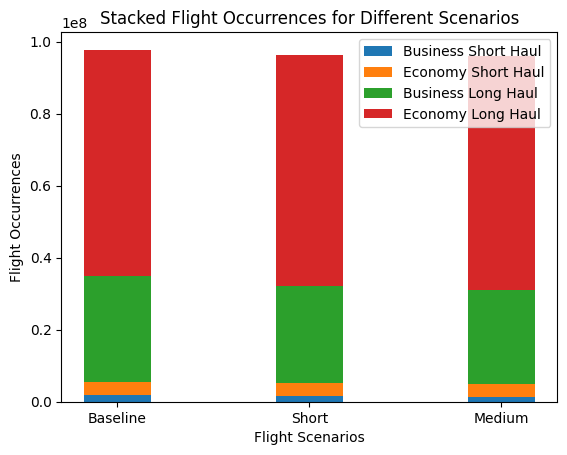

In [81]:
# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
plt.bar(x, business_short_haul, width=bar_width, label='Business Short Haul')
plt.bar(x, economy_short_haul, bottom=business_short_haul, width=bar_width, label='Economy Short Haul')
plt.bar(x, business_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul), width=bar_width, label='Business Long Haul')
plt.bar(x, economy_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul) + np.array(business_long_haul), width=bar_width, label='Economy Long Haul')

# Adding labels
plt.xlabel('Flight Scenarios')
plt.ylabel('Flight Occurrences')
plt.title('Stacked Flight Occurrences for Different Scenarios')
plt.xticks(x, scenarios)
plt.legend()

# Show plot
plt.show()


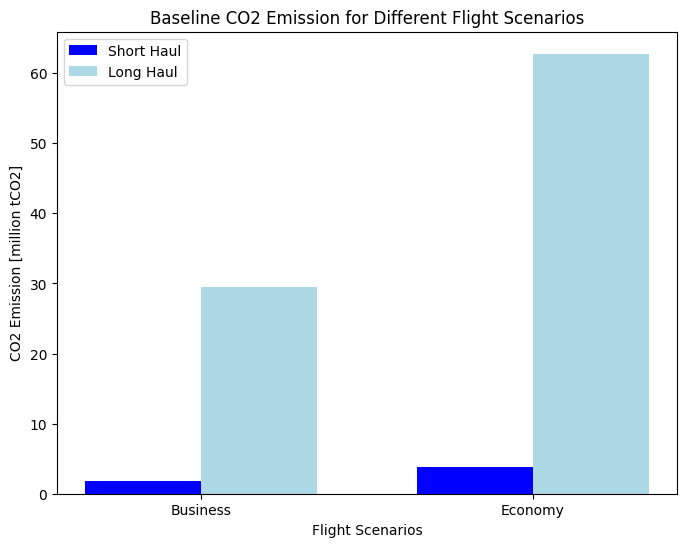

In [114]:

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, baseline_short, width=bar_width, label='Short Haul', color='blue')
plt.bar(x + bar_width/2, baseline_long, width=bar_width, label='Long Haul', color='lightblue')

# Adding labels
plt.ylabel('CO2 Emission [million tCO2]')
plt.xlabel('Flight Scenarios')
plt.title('Baseline CO2 Emission for Different Flight Scenarios')
plt.xticks(x, scenarios)
plt.legend()

# Show plot
plt.show()

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
baseline_short = [baseline_short_business, baseline_short_economy]
baseline_long = [baseline_long_business, baseline_long_economy]
scenarios = ['Business', 'Economy']

# Convert the data to million tons
baseline_short = [value / 1e6 for value in baseline_short]
baseline_long = [value / 1e6 for value in baseline_long]

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the y-axis
y = np.arange(len(scenarios))

plt.figure(figsize=(15, 3))
# Plotting
plt.barh(y + bar_width/2, baseline_short, height=bar_width, label='Short Haul', color='blue')
plt.barh(y - bar_width/2, baseline_long, height=bar_width, label='Long Haul', color='lightblue')

# Adding labels
plt.xlabel('CO2 Emission [thousand tCO2]')
# plt.ylabel('Flight Scenarios')
# plt.title('Baseline Flight Occurrences for Different Scenarios')
plt.yticks(y, scenarios)
plt.legend()

# Show plot
plt.show()


TypeError: bar() got multiple values for argument 'height'

<Figure size 1500x300 with 0 Axes>

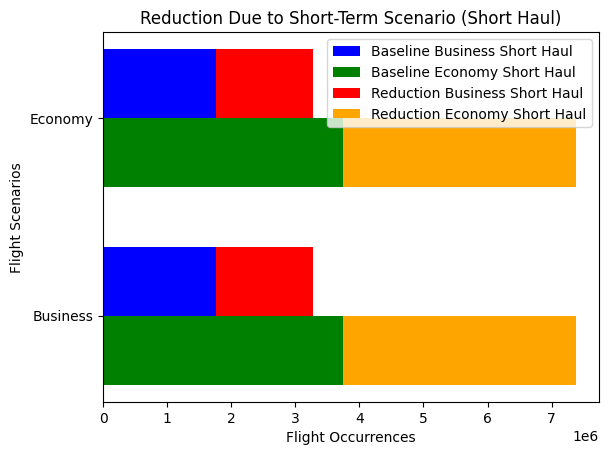

In [83]:

scenarios = ['Business', 'Economy']

# Calculate the reduction due to the short-term scenario
reduction_business_short = baseline_short_business - change_short_business
reduction_economy_short = baseline_short_economy - change_short_economy

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the y-axis
y = np.arange(len(scenarios))

# Plotting
plt.barh(y + bar_width/2, baseline_short_business, height=bar_width, label='Baseline Business Short Haul', color='blue')
plt.barh(y - bar_width/2, baseline_short_economy, height=bar_width, label='Baseline Economy Short Haul', color='green')
plt.barh(y + bar_width/2, change_short_business, height=bar_width, label='Reduction Business Short Haul', color='red', left=baseline_short_business)
plt.barh(y - bar_width/2, change_short_economy, height=bar_width, label='Reduction Economy Short Haul', color='orange', left=baseline_short_economy)

# Adding labels
plt.xlabel('Flight Occurrences')
plt.ylabel('Flight Scenarios')
plt.title('Reduction Due to Short-Term Scenario (Short Haul)')
plt.yticks(y, scenarios)
plt.legend()

# Show plot
plt.show()

In [84]:
# Define offset for annotation
annotation_offset = 10

# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_baseline = baseline_short_business + baseline_short_economy + baseline_long_business + baseline_long_economy
total_short = change_short_business + change_short_economy + change_long_business + change_long_economy
total_medium = change_short_business_new + change_short_economy_new + change_long_business_new + change_long_economy_new

# Calculate total CO2 reduction
total_reduction_short = total_baseline - total_short
total_reduction_medium = total_short - total_medium

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
fig = go.Figure()

fig.add_trace(go.Bar(x=x, y=business_short_haul, name='Business Short Haul', marker_color='blue'))
fig.add_trace(go.Bar(x=x, y=economy_short_haul, name='Economy Short Haul', marker_color='lightblue'))
fig.add_trace(go.Bar(x=x, y=business_long_haul, name='Business Long Haul', marker_color='green'))
fig.add_trace(go.Bar(x=x, y=economy_long_haul, name='Economy Long Haul', marker_color='lightgreen'))

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage = (total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (total_reduction_medium / total_short) * 100
#     rounded_percentage = round(reduction_percentage, 2)
#     fig.add_annotation(x=x[i], y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + 5,
#                        text=f"Total reduction: {rounded_percentage}%",
#                        showarrow=False, xanchor='center', yanchor='bottom')

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage_short = (1 - total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (1 - total_reduction_medium / total_short) * 100
#     rounded_percentage_short = round(reduction_percentage_short, 2)
    
#     reduction_percentage_long = (1 - total_reduction_long / total_baseline) * 100 if scenarios[i] == 'Medium' else (1 - total_reduction_medium / total_medium) * 100
#     rounded_percentage_long = round(reduction_percentage_long, 2)
    
#     fig.add_annotation(x=i, y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + annotation_offset,
#                        text=f"Total reduction: {rounded_percentage_short}% (Short), {rounded_percentage_long}% (Long)",
#                        showarrow=False, xanchor='center', yanchor='bottom')


# Adding labels and title
fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=x, ticktext=scenarios),
    yaxis=dict(title='Total CO2 emission [kg]'),
    title='Stacked Flight Occurrences for Different Scenarios',
    barmode='stack',
    legend=dict(x=1.02, y=1),
    width=800,  # Adjust plot width
    height=500  # Adjust plot height
)

fig.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_21684\1068413828.py:33: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



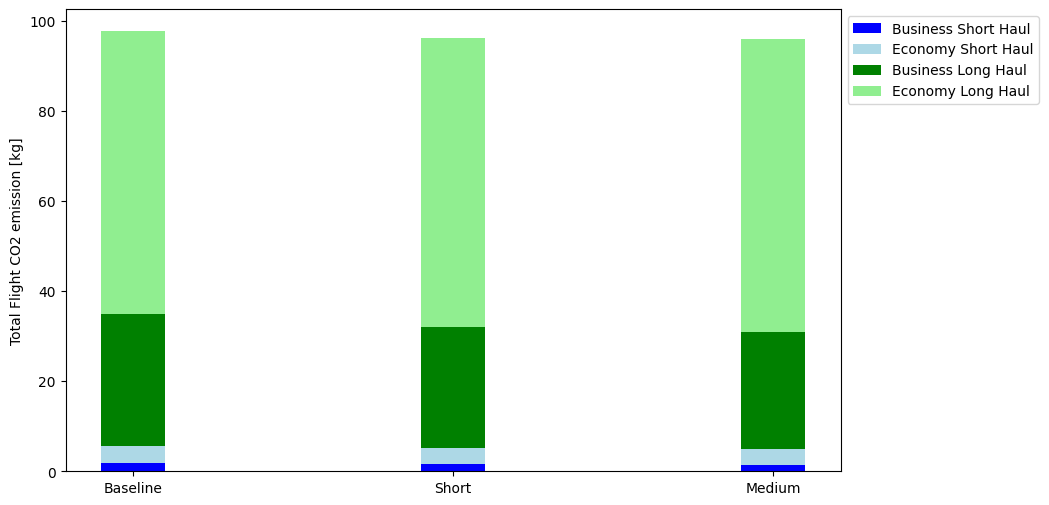

In [110]:

# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_business_short = [baseline_short_business + change_short_business + change_short_business_new]
total_economy_short = [baseline_short_economy + change_short_economy + change_short_economy_new]
total_business_long = [baseline_long_business + change_long_business + change_long_business_new]
total_economy_long = [baseline_long_economy + change_long_economy + change_long_economy_new]

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(x, business_short_haul, width=bar_width, label='Business Short Haul', color='blue')
plt.bar(x, economy_short_haul, bottom=business_short_haul, width=bar_width, label='Economy Short Haul', color='lightblue')
plt.bar(x, business_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul), width=bar_width, label='Business Long Haul', color='green')
plt.bar(x, economy_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul) + np.array(business_long_haul), width=bar_width, label='Economy Long Haul', color='lightgreen')

# Adding labels
plt.ylabel('Total Flight CO2 emission [kg]')
plt.xticks(x, scenarios)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of the plot area

# Manually setting y-axis tick labels in units of 100m
plt.gca().set_yticklabels(['{:.0f}'.format(tick /1000000) for tick in plt.gca().get_yticks()])

# Show plot
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_21684\2421421148.py:56: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



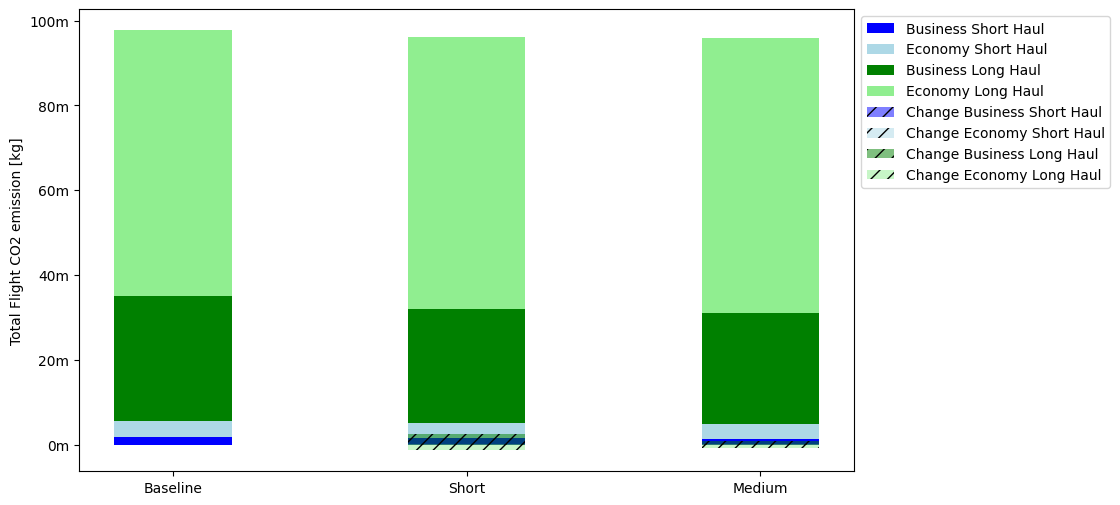

In [86]:
    import matplotlib.pyplot as plt
import numpy as np

# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_business_short = [baseline_short_business + change_short_business + change_short_business_new]
total_economy_short = [baseline_short_economy + change_short_economy + change_short_economy_new]
total_business_long = [baseline_long_business + change_long_business + change_long_business_new]
total_economy_long = [baseline_long_economy + change_long_economy + change_long_economy_new]

# Calculate the changes for each category
changes_business_short = [baseline_short_business - change_short_business, change_short_business - change_short_business_new]
changes_economy_short = [baseline_short_economy - change_short_economy, change_short_economy - change_short_economy_new]
changes_business_long = [baseline_long_business - change_long_business, change_long_business - change_long_business_new]
changes_economy_long = [baseline_long_economy - change_long_economy, change_long_economy - change_long_economy_new]

# Define the width of the bars
bar_width = 0.4

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting business short haul
plt.bar(x, business_short_haul, width=bar_width, label='Business Short Haul', color='blue')

# Plotting economy short haul
plt.bar(x, economy_short_haul, bottom=business_short_haul, width=bar_width, label='Economy Short Haul', color='lightblue')

# Plotting business long haul
plt.bar(x, business_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul), width=bar_width, label='Business Long Haul', color='green')

# Plotting economy long haul
plt.bar(x, economy_long_haul, bottom=np.array(business_short_haul) + np.array(economy_short_haul) + np.array(business_long_haul), width=bar_width, label='Economy Long Haul', color='lightgreen')

# Plotting changes as waterfall bars
plt.bar(x[1:], changes_business_short, bottom=[0, 0], width=bar_width, color='blue', alpha=0.5, hatch='//', label='Change Business Short Haul')
plt.bar(x[1:], changes_economy_short, bottom=[0, 0], width=bar_width, color='lightblue', alpha=0.5, hatch='//', label='Change Economy Short Haul')
plt.bar(x[1:], changes_business_long, bottom=[0, 0], width=bar_width, color='green', alpha=0.5, hatch='//', label='Change Business Long Haul')
plt.bar(x[1:], changes_economy_long, bottom=[0, 0], width=bar_width, color='lightgreen', alpha=0.5, hatch='//', label='Change Economy Long Haul')

# Adding labels
plt.ylabel('Total Flight CO2 emission [kg]')
plt.xticks(x, scenarios)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside of the plot area

# Manually setting y-axis tick labels in units of 100m
plt.gca().set_yticklabels(['{:.0f}m'.format(tick / 1000000) for tick in plt.gca().get_yticks()])

# Show plot
plt.show()


In [87]:
# Define offset for annotation
annotation_offset = 10

# Example data
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_baseline = baseline_short_business + baseline_short_economy + baseline_long_business + baseline_long_economy
total_short = change_short_business + change_short_economy + change_long_business + change_long_economy
total_medium = change_short_business_new + change_short_economy_new + change_long_business_new + change_long_economy_new

# Calculate total CO2 reduction
total_reduction_short = total_baseline - total_short
total_reduction_medium = total_short - total_medium

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = np.arange(len(scenarios))

# Plotting
fig = go.Figure()

fig.add_trace(go.Bar(x=x, y=business_short_haul, name='Business Short Haul', marker_color='blue'))
fig.add_trace(go.Bar(x=x, y=economy_short_haul, name='Economy Short Haul', marker_color='lightblue'))
fig.add_trace(go.Bar(x=x, y=business_long_haul, name='Business Long Haul', marker_color='green'))
fig.add_trace(go.Bar(x=x, y=economy_long_haul, name='Economy Long Haul', marker_color='lightgreen'))

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage = (total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (total_reduction_medium / total_short) * 100
#     rounded_percentage = round(reduction_percentage, 2)
#     fig.add_annotation(x=x[i], y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + 5,
#                        text=f"Total reduction: {rounded_percentage}%",
#                        showarrow=False, xanchor='center', yanchor='bottom')

# # Displaying reduction as total CO2 reduction
# for i in range(1, len(scenarios)):
#     reduction_percentage_short = (1 - total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (1 - total_reduction_medium / total_short) * 100
#     rounded_percentage_short = round(reduction_percentage_short, 2)
    
#     reduction_percentage_long = (1 - total_reduction_long / total_baseline) * 100 if scenarios[i] == 'Medium' else (1 - total_reduction_medium / total_medium) * 100
#     rounded_percentage_long = round(reduction_percentage_long, 2)
    
#     fig.add_annotation(x=i, y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + annotation_offset,
#                        text=f"Total reduction: {rounded_percentage_short}% (Short), {rounded_percentage_long}% (Long)",
#                        showarrow=False, xanchor='center', yanchor='bottom')


# Adding labels and title
fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=x, ticktext=scenarios),
    yaxis=dict(title='Total CO2 emission [kg]'),
    title='Stacked Flight Occurrences for Different Scenarios',
    barmode='stack',
    legend=dict(x=1.02, y=1),
    width=800,  # Adjust plot width
    height=500  # Adjust plot height
)

fig.show()


In [88]:
business_short_haul = [baseline_short_business, change_short_business, change_short_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_short_haul = [baseline_short_economy, change_short_economy, change_short_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
business_long_haul = [baseline_long_business, change_long_business, change_long_business_new]  # Occurrences for BSH: Baseline, Short, Medium
economy_long_haul = [baseline_long_economy, change_long_economy, change_long_economy_new]  # Occurrences for ESH: Baseline, Short, Medium
scenarios = ['Baseline', 'Short', 'Medium']

# Calculate total at the top of each column
total_business_short = sum(business_short_haul)
total_economy_short = sum(economy_short_haul)
total_business_long = sum(business_long_haul)
total_economy_long = sum(economy_long_haul)

# Calculate total CO2 reduction
total_reduction_short = total_baseline - total_short
total_reduction_medium = total_short - total_medium

# Define offset for annotation
annotation_offset = 10

# Plotly setup
fig = go.Figure()

# Adding bars for each scenario
fig.add_trace(go.Bar(x=scenarios, y=business_short_haul, name='Business Short Haul', marker_color='blue'))
fig.add_trace(go.Bar(x=scenarios, y=economy_short_haul, name='Economy Short Haul', marker_color='lightblue'))
fig.add_trace(go.Bar(x=scenarios, y=business_long_haul, name='Business Long Haul', marker_color='green'))
fig.add_trace(go.Bar(x=scenarios, y=economy_long_haul, name='Economy Long Haul', marker_color='lightgreen'))

# Displaying reduction as total CO2 reduction
for i in range(1, len(scenarios)):
    reduction_percentage_short = (total_reduction_short / total_baseline) * 100 if scenarios[i] == 'Short' else (total_reduction_medium / total_short) * 100
    rounded_percentage_short = round(reduction_percentage_short, 2)
    
    reduction_percentage_long = (total_reduction_long / total_baseline) * 100 if scenarios[i] == 'Medium' else (total_reduction_medium / total_medium) * 100
    rounded_percentage_long = round(reduction_percentage_long, 2)
    
    fig.add_annotation(x=i, y=sum([business_short_haul[i], economy_short_haul[i], business_long_haul[i], economy_long_haul[i]]) + annotation_offset,
                       text=f"Total reduction: {rounded_percentage_short}% (Short), {rounded_percentage_long}% (Long)",
                       showarrow=False, xanchor='center', yanchor='bottom')

# Update layout
fig.update_layout(barmode='stack', 
                  title='Stacked Flight Occurrences for Different Scenarios', 
                  xaxis_title='Flight Scenarios', 
                  yaxis_title='Flight Occurrences', 
                  legend=dict(x=1.02, y=1, bgcolor='rgba(255, 255, 255, 0)', bordercolor='rgba(255, 255, 255, 0)'), plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()